In [3]:
 from google.colab import drive
 drive. mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 4
EPOCHS = 20

# Dice Functions
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Data Loading Function
def load_data(image_dir, mask_dir):
    images, masks = [], []
    img_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = image / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        if np.mean(mask) > 127:
            mask = 255 - mask
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Data Augmentation Function
def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotation (by 0, 90, 180, or 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    return image, mask

# tf.data Pipeline
def create_dataset(images, masks, augment_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(100)
    if augment_data:
        dataset = dataset.map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# U-Net Model
def unet_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    def conv_block(x, filters):
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    u6 = Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=dice_loss, metrics=[dice_coefficient])
    return model

# Main Training Flow
image_dir = "/content/drive/MyDrive/data/img"
mask_dir = "/content/drive/MyDrive/data/mask"

X, Y = load_data(image_dir, mask_dir)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = create_dataset(X_train, Y_train, augment_data=True)
val_dataset = create_dataset(X_val, Y_val, augment_data=False)

model = unet_model()
model.summary()

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Final evaluation
loss, dice = model.evaluate(val_dataset)
print(f"Validation Dice Score: {dice:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_10… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_11… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - dice_coefficient: 0.3819 - loss: 0.6181 - val_dice_coefficient: 0.6308 - val_loss: 0.3688
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 69s 246ms/step - dice_coefficient: 0.6498 - loss: 0.3502 - val_dice_coefficient: 0.6731 - val_loss: 0.3275
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - dice_coefficient: 0.7450 - loss: 0.2550 - val_dice_coefficient: 0.8698 - val_loss: 0.1283
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - dice_coefficient: 0.8708 - loss: 0.1292 - val_dice_coefficient: 0.8916 - val_loss: 0.1089
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - dice_coefficient: 0.8921 - loss: 0.1079 - val_dice_coefficient: 0.8968 - val_loss: 0.1031
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - dice_coefficient: 0.9065 - loss: 0.0935 - val_dice_coefficient: 0.9110 - val_loss: 0.0883
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 258ms/step - dice_coefficient: 0.9159 - loss: 0.0841 - val_dice_coefficien

4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step


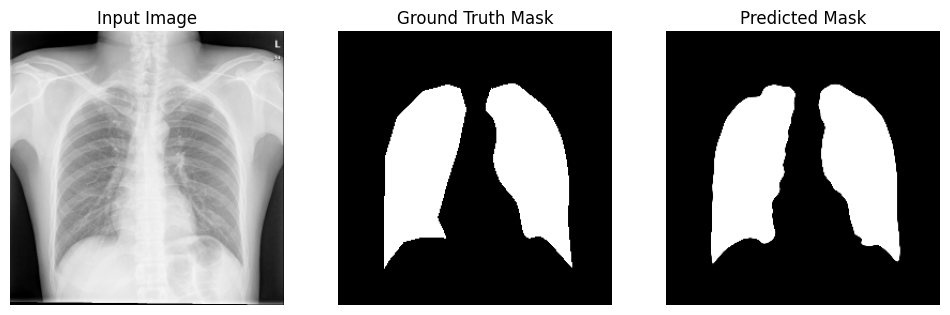

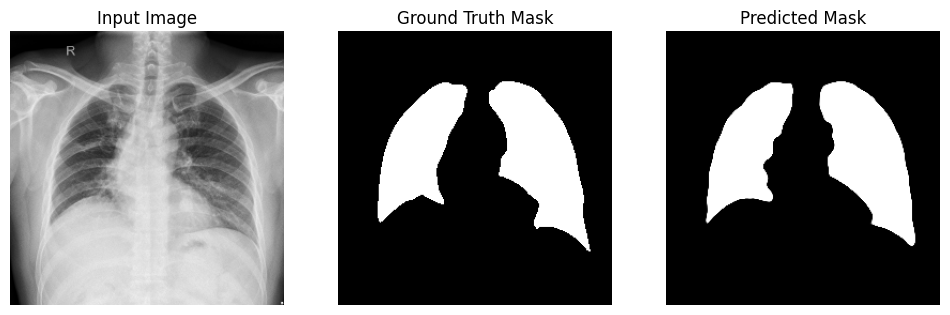

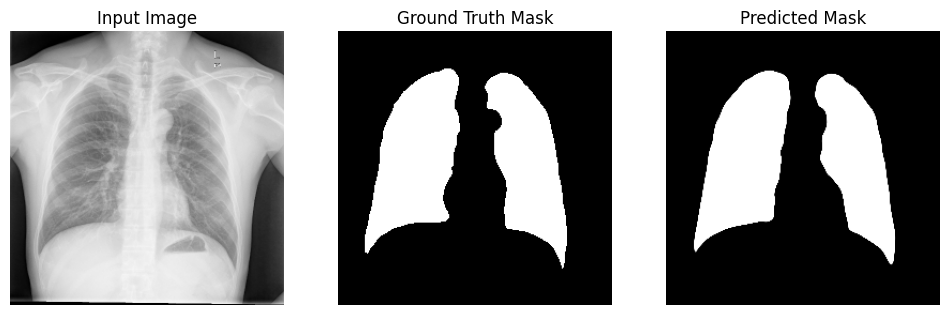

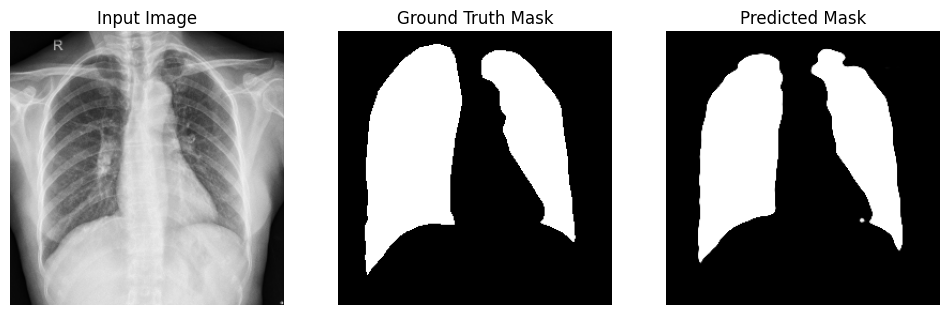

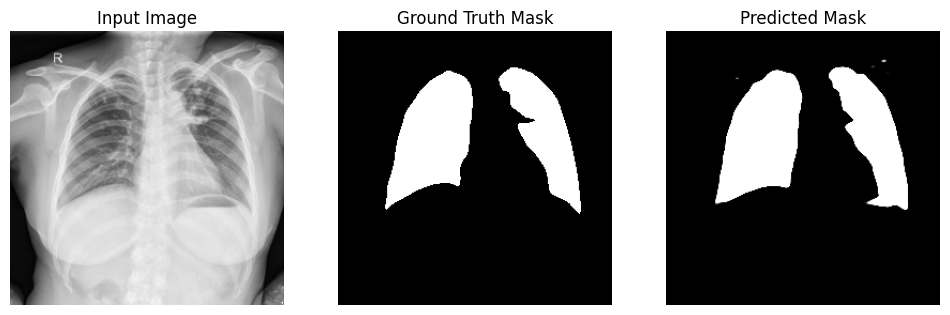

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize input, ground truth, and predicted mask
def visualize_results(X_test, Y_test, preds, num_samples=15):
    """
    Visualizes a set of test images, their ground truth masks, and the model's predicted masks.

    Args:
    X_test: The input images (numpy array of shape [num_samples, height, width, channels])
    Y_test: The ground truth masks (numpy array of shape [num_samples, height, width, 1])
    preds: The model's predicted masks (numpy array of shape [num_samples, height, width, 1])
    num_samples: Number of samples to visualize (default is 15)
    """
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])  # Show RGB image
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(Y_test[i].squeeze(), cmap="gray")  # Ground truth mask in grayscale
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap="gray")  # Predicted mask in grayscale
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# After training your model, you will generate predictions using:
# preds = model.predict(X_val)

# Assuming X_val, Y_val, and preds are available, you can call the visualization function like this:
preds = model.predict(X_val)  # Model's predictions on the validation set

visualize_results(X_val, Y_val, preds, num_samples=5)


In [11]:
# Convert ground truth to binary 0 or 1
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Convert predictions to binary 0 or 1 using threshold
preds_binary = (preds > 0.5).astype(np.uint8)

# Flatten for confusion matrix
y_true_flat = Y_val_binary.reshape(-1)
y_pred_flat = preds_binary.reshape(-1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step


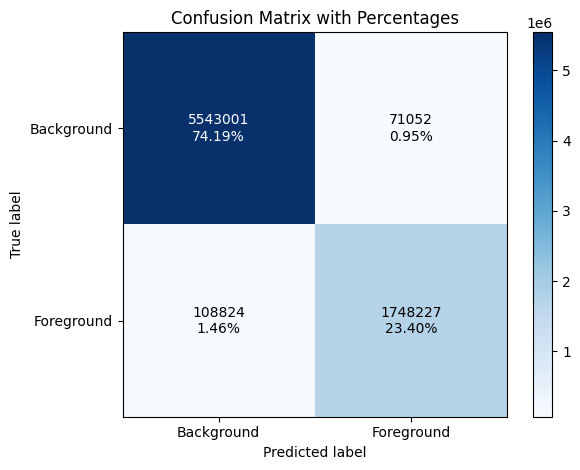


Classification Report:
              precision    recall  f1-score   support

  Background       0.98      0.99      0.98   5614053
  Foreground       0.96      0.94      0.95   1857051

    accuracy                           0.98   7471104
   macro avg       0.97      0.96      0.97   7471104
weighted avg       0.98      0.98      0.98   7471104



In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Predict and binarize
preds = model.predict(X_val)
preds_binary = (preds > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Flatten
y_true_flat = Y_val_binary.reshape(-1).astype(np.uint8)
y_pred_flat = preds_binary.reshape(-1).astype(np.uint8)

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_sum = cm.sum()

# Create percentage matrix
cm_percentage = cm / cm_sum * 100

# Plot with annotations
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Labels and titles
classes = ["Background", "Foreground"]
tick_marks = np.arange(len(classes))
ax.set(xticks=tick_marks,
       yticks=tick_marks,
       xticklabels=classes,
       yticklabels=classes,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix with Percentages')

# Annotate cells with counts and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i,
                f"{cm[i, j]}\n{cm_percentage[i, j]:.2f}%",
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=classes))
